### Imports

In [399]:
import cv2
import glob
import os
import sys
import numpy as np
import json
import itertools
from collections import defaultdict


from matplotlib import pyplot as plt
%matplotlib inline


In [400]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Reading

In [439]:
# paths 
cityscapesPath = os.path.normpath(os.path.join(os.path.dirname('__file__'), '..', 'data/cityscapes'))
img_dir = 'leftImg8bit'
path_left_imgs = os.path.normpath(os.path.join(cityscapesPath,img_dir))

# default dictionary of cities
cities = defaultdict(list)
modes = ['train','test','val']
for mode in modes:
    for (dirpath, dirnames, filenames) in os.walk(path_left_imgs+'/'+mode):
        cities[mode] = dirnames 
        break
        
mode = 'train'
city = 'zurich'

# returns list of paths to imgs for this city
def ReadImgPaths(mode=mode, city=city):
    
    # absolute path to the directory with images
    path_imgs_dir = os.path.normpath(os.path.join(cityscapesPath,img_dir, mode, city))
    # list of absolute paths to images
    path_imgs = glob.glob(path_imgs_dir + '/*.png')
    path_imgs.sort()
    
    print 'ReadImgPaths.','%s %s: number of images is' %(mode,city), len(path_imgs)
    
    return path_imgs


# returns list of paths to disparity imgs for this city
def ReadDispPaths(mode=mode, city=city):
    
    # absolute path to the directory with disparities
    path_disp_dir = os.path.normpath(os.path.join(cityscapesPath,'disparity', mode, city))
    # list of absolute paths to disparities
    path_disp_imgs = glob.glob(path_disp_dir + '/*.png')
    path_disp_imgs.sort()
    
    print 'ReadDispPaths.', '%s %s: number of disparity images is' %(mode,city), len(path_disp_imgs)
    
    return path_disp_imgs


# returns list of paths to annotations for this city
def ReadAnnoPaths(mode=mode, city=city):
      
    # absolute path to the directory with annotations
    path_anno_dir = os.path.normpath(os.path.join(cityscapesPath,'gtFine', mode, city))
    # list of absolute paths to annotations
    path_anno = glob.glob(path_anno_dir + '/*.json')
    path_anno.sort()
    
    print 'ReadAnnoPaths.', '%s %s: number of annotations is' %(mode,city), len(path_anno)
    
    return path_anno
    
    
def ReadAnnoImgPath(mode=mode, city=city):
    
        # absolute path to the directory with annotations
    path_anno_dir = os.path.normpath(os.path.join(cityscapesPath,'gtFine', mode, city))
    # list of absolute paths to annotations
    path_anno_imgs = glob.glob(path_anno_dir + '/*color.png')
    path_anno_imgs.sort()
    
    print 'ReadAnnoPaths.', '%s %s: number of annotations is' %(mode,city), len(path_anno_imgs)
    
    return path_anno_imgs

    
# find a disparity for the image path
def DispForImg(img_path, mode=mode, city=city):
    
    path_disp_dir = os.path.normpath(os.path.join(cityscapesPath,'disparity', mode, city))
    
    # take a tail of img path
    img_name = os.path.split(img_path)[1]
    # remove extention
    img_name = os.path.splitext(img_name)[0]
    # take img number
    img_number = img_name[:-len(img_dir)]
    # abs path to the corresponded disparity
    path_disp_img = glob.glob(path_disp_dir +'/'+ str(img_number)+'*')[0]
    
    return path_disp_img


# find the annotation for the image path
def AnnoForImg(img_path, mode=mode, city=city):
    
    path_anno_dir = os.path.normpath(os.path.join(cityscapesPath,'gtFine', mode, city))
    
    # take a tail of img path
    img_name = os.path.split(img_path)[1]
    # remove extention
    img_name = os.path.splitext(img_name)[0]
    # take img number
    img_number = img_name[:-len(img_dir)]
    # abs path to the corresponded annotation
    path_anno = glob.glob(path_anno_dir +'/'+ str(img_number)+'*'+'.json')[0]
    
    return path_anno

# extract the polygons correspond to the label
def ExtractPolygon(json_file, label='road'):
    
    with open(json_file) as anno:    
        data = json.load(anno)
    polygon = [d['polygon'] for d in data["objects"] if d['label'] == label][0]  
    
    return np.array(polygon)


# make disparitis = 0 for the road points
def ExcludeRoadDisp(img, anno_img):

    excl_road = (anno_img != np.array([[[128, 64, 128]]]))[:, :, 0].astype(np.uint8)
#     excl_sign = (anno_img != np.array([[[128, 64, 128]]]))[:, :, 0].astype(np.uint8)
    masked_image = cv2.bitwise_and(img, img, mask=excl_road)
    
    return masked_image


# calculate max disparity excluding road points
def MaxDispValue(disp_img, mode=mode, city=city):

    return np.max(disp_img)


def CropRoI(img_path):
    
    # original image
    # -1 loads as-is so if it will be 3 or 4 channel as the original
    img = cv2.imread(img_path, -1)
    
    y_shape,x_shape,_ = img.shape
    
    X = np.zeros(4)
    Y = np.zeros(4)
    
    #top left
    X[0] = x_shape // 3
    Y[0] = y_shape // 3
    
    #bottom left
    X[1] = 0
    Y[1] = y_shape
    
    #bottom right
    X[2] = x_shape
    Y[2] = Y[1]
    
    #top right
    X[3] = 9 * x_shape // 10
    Y[3] = Y[0]
    
    # mask defaulting to black for 3-channel and transparent for 4-channel
    # (of course replace corners with yours)
    mask = np.zeros(img.shape, dtype=np.uint8)
    roi_corners = np.array([zip(X, Y)], dtype=np.int32)
    # fill the ROI so it doesn't get wiped out when the mask is applied
    channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
    ignore_mask_color = (255,)*channel_count
    cv2.fillPoly(mask, roi_corners, ignore_mask_color)

    # apply the mask
    masked_image = cv2.bitwise_and(img, mask)

    # save the result
    #cv2.imwrite('image_masked.png', masked_image)
    
    return masked_image



def Plot(img):
    plt.figure(figsize = (10,5))
    plt.imshow(img)

## Test

In [440]:
imgs_paths = ReadImgPaths()
disp_imgs_paths = ReadDispPaths()
annos_paths = ReadAnnoPaths()
anno_imgs_paths = ReadAnnoImgPath()

print disp_imgs_paths[0]

ReadImgPaths. train zurich: number of images is 122
ReadDispPaths. train zurich: number of disparity images is 122
ReadAnnoPaths. train zurich: number of annotations is 122
ReadAnnoPaths. train zurich: number of annotations is 122
../data/cityscapes/disparity/train/zurich/zurich_000000_000019_disparity.png


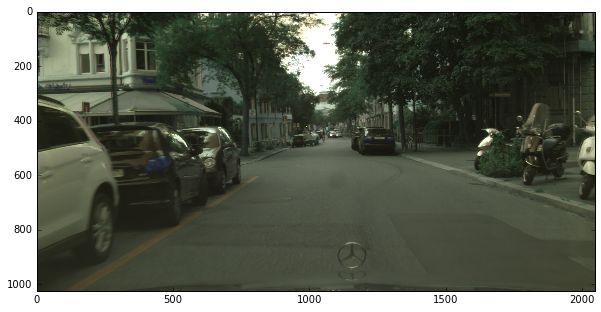

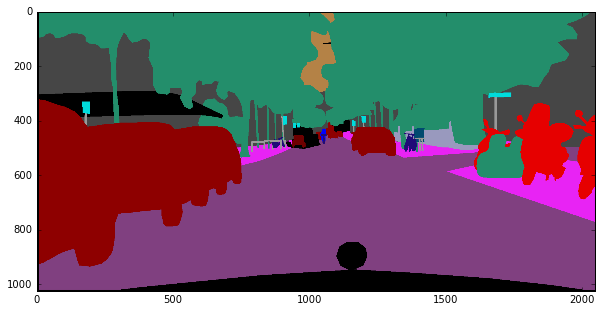

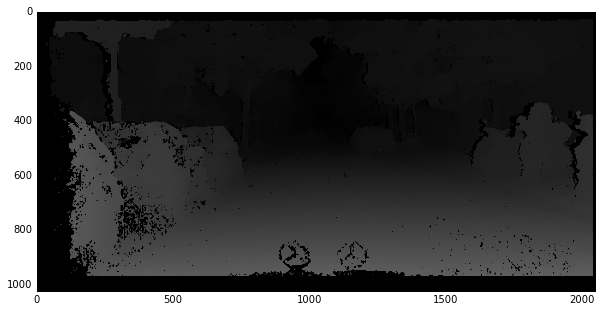

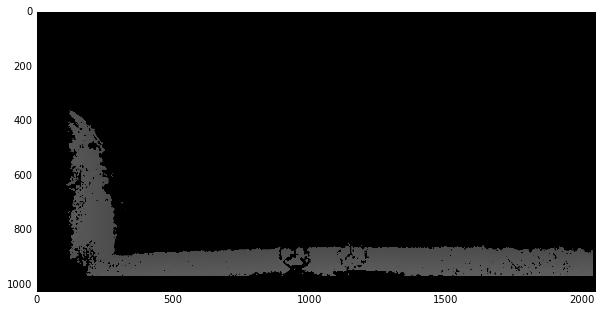

In [441]:
# good example nmb_image = 41, 12
i = np.random.randint(0,len(disp_imgs_paths))

disp = cv2.imread(disp_imgs_paths[i])
img = cv2.imread(imgs_paths[i])
img_path = imgs_paths[i]
anno_img = cv2.imread(anno_imgs_paths[i])

Plot(img)
Plot(anno_img)

''' All disparity'''
Plot(disp)

''' Disparity in percentile '''
disp_perc = disp.copy()
disp_perc[disp < np.percentile(disp, 90)] = 0
Plot(disp_perc)

## Disparities in the percentile

123


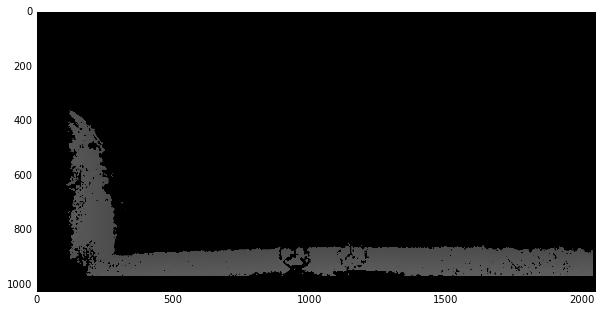

In [442]:
disp_perc = disp.copy()
disp_perc[disp < np.percentile(disp, 90)] = 0
print disp.max()
Plot(disp_perc)

## Image's pixels correspondes to disparity in the percentile

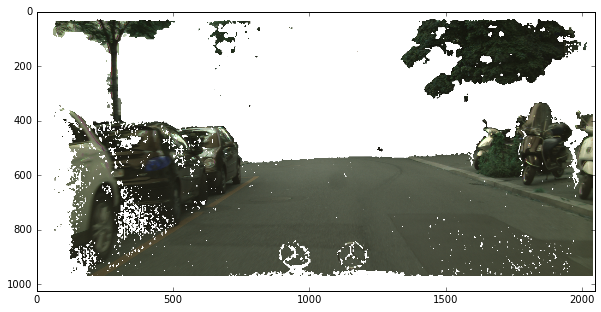

In [443]:
img_perc = img.copy()
img_perc[disp < np.percentile(disp, 50)] = 255
Plot(img_perc)

## RoI, Cropped image

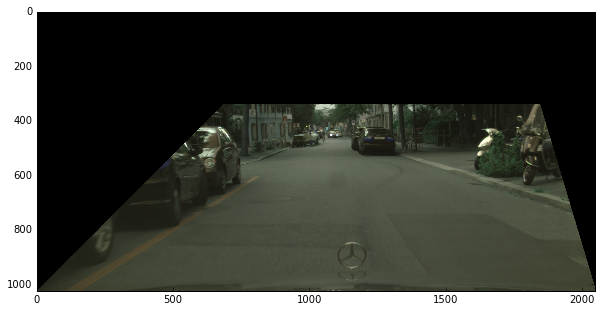

In [444]:
Plot(CropRoI(img_path))

## Exluding Road

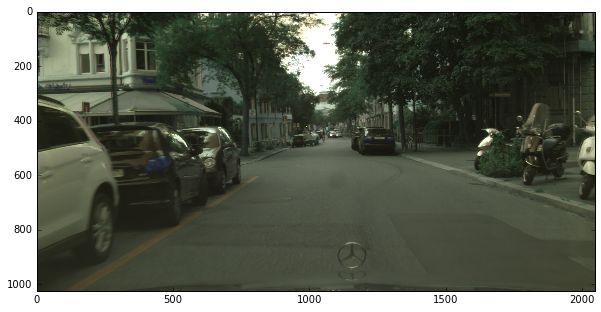

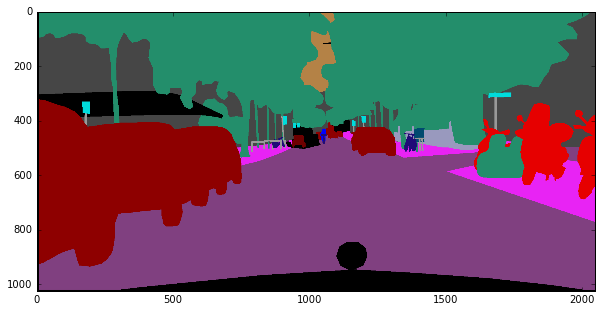

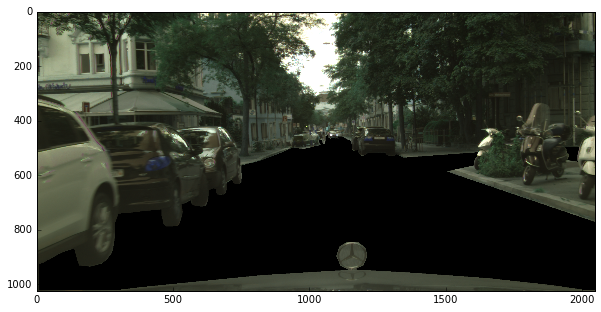

In [445]:
Plot(img)
Plot(anno_img)
masked_img = ExcludeRoadDisp(img, anno_img)
Plot(masked_img)

## Histogram of max disparties for this city

122


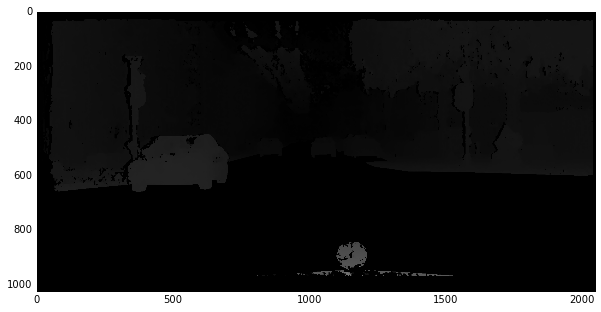

In [448]:
max_disps = []
print len(disp_imgs_paths)
for i in range (len(disp_imgs_paths)):
    disp = cv2.imread(disp_imgs_paths[i])
    anno = cv2.imread(anno_imgs_paths[i])
    excl_img = ExcludeRoadDisp(disp, anno)
    max_disps.append(excl_img.max())

In [ ]:
Plot(excl_img)

(array([  3.,   0.,   1.,   2.,   0.,   0.,   3.,   0.,   3.,   0.,   0.,
          2.,   3.,   1.,   1.,   2.,   3.,   0.,   4.,   4.,   4.,   7.,
          5.,   6.,  68.]),
 array([  97.  ,   98.16,   99.32,  100.48,  101.64,  102.8 ,  103.96,
         105.12,  106.28,  107.44,  108.6 ,  109.76,  110.92,  112.08,
         113.24,  114.4 ,  115.56,  116.72,  117.88,  119.04,  120.2 ,
         121.36,  122.52,  123.68,  124.84,  126.  ]),
 <a list of 25 Patch objects>)

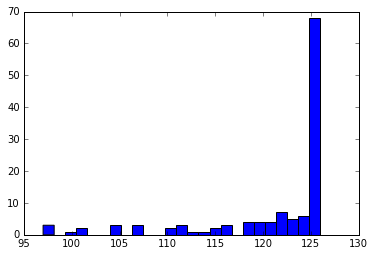

In [447]:
plt.hist(max_disps, bins=25)